In [1]:

import numpy as np
import keras
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import plot_model

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization, LayerNormalization
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import KFold
import tensorflow as tf
from tensorflow.keras.models import load_model

In [2]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import MultiLabelBinarizer


def generate_class_weights(class_series, multi_class=True, one_hot_encoded=False):
  if multi_class:
    # If class is one hot encoded, transform to categorical labels to use compute_class_weight   
    if one_hot_encoded:
      class_series = np.argmax(class_series, axis=1)
  
    # Compute class weights with sklearn method
    class_labels = np.unique(class_series)
    class_weights = compute_class_weight(class_weight='balanced', classes=class_labels, y=class_series)
    return dict(zip(class_labels, class_weights))
  else:
    # It is neccessary that the multi-label values are one-hot encoded
    mlb = None
    if not one_hot_encoded:
      mlb = MultiLabelBinarizer()
      class_series = mlb.fit_transform(class_series)

    n_samples = len(class_series)
    n_classes = len(class_series[0])

    # Count each class frequency
    class_count = [0] * n_classes
    for classes in class_series:
        for index in range(n_classes):
            if classes[index] != 0:
                class_count[index] += 1
    
    # Compute class weights using balanced method
    class_weights = [n_samples / (n_classes * freq) if freq > 0 else 1 for freq in class_count]
    class_labels = range(len(class_weights)) if mlb is None else mlb.classes_
    return dict(zip(class_labels, class_weights))

In [3]:
#Load colorplot datasets. 
X = np.load('reduced_data.npz')['a'].reshape(1000, 200, 100, 1)

#Creating the labels. 
y = pd.read_excel('Labels_v1.xlsx', header = None, sheet_name='Reduced').values

#Shuffling the dataset.
shuffler = np.random.permutation(len(y))
X = X[shuffler]
y = y[shuffler]
class_weights = generate_class_weights(y[:,0])

In [4]:
def train(net, filename):
    # Define the K-fold Cross Validator
    num_folds = 5
    kfold = KFold(n_splits=num_folds, shuffle=True)

    es = EarlyStopping(monitor='val_loss', mode='min', patience=20, min_delta=0.2)
    
    opt = tf.keras.optimizers.Adam(
    learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False,
    name="Adam",    
    )
    
    net.compile(loss='binary_crossentropy',
                optimizer=opt, metrics="accuracy")

    inputs = X
    targets = np.asarray(y).astype('float32').reshape((-1,1))
    # K-fold Cross Validation model evaluation
    fold_no = 1
    for train, test in kfold.split(inputs, targets):
        #Train the model
        history = net.fit(
        inputs[train], targets[train],                         # changed expression for test features and labels
        validation_split=0.25,                                 # I removed validation for k-fold cross validation
        verbose=1, epochs=25, 
        class_weight = class_weights, callbacks=[es])
        
        plt.figure()
        plt.plot(history.history['loss'], label='training loss')
        plt.plot(history.history['val_loss'], label='validation loss')
        plt.xlabel('epochs')
        plt.ylabel('loss')
        plt.legend()

        plt.show()
        #Prediction of the validation dataset 
        test_predictions = net.predict(inputs[test]).flatten()
        fold_no = fold_no + 1

    net.save(filename)

In [5]:

def build_cnn():
    net = Sequential()
    net.add(Conv2D(activation='relu',filters=32, kernel_size=(5, 5), input_shape=(200, 100, 1)))
    net.add(BatchNormalization())
    net.add(Conv2D(64, (3, 3), activation='relu'))
    net.add(MaxPool2D(pool_size=(2, 2)))
    net.add(Flatten())
    net.add(Dense(256, activation='relu'))
    net.add(Dropout(rate=0.5))
    net.add(Dense(10, activation='sigmoid'))
    net.add(Flatten())

    # net.build(input_shape=(200, 100, 1))
    summary = net.summary()

    plot_model(net, to_file='network_structure.png', show_shapes=True)

    print(summary)

    return net

In [6]:
def test(filename):
    net = load_model(filename)
    labels_train = y
    
    outputs = net.predict(X)
    labels_predicted = np.argmax(outputs, axis=1)
    misclassified = sum(labels_predicted != labels_train)
    print('Percentage misclassified = ',
          100*misclassified/labels_train.size)

    plt.figure(figsize=(8, 2))
    for i in range(0, 8):
        ax = plt.subplot(2, 8, i+1)
        plt.imshow(X[i, :].reshape(200, 100), cmap=plt.get_cmap('gray_r'))
        plt.title(labels_train[i])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    for i in range(0, 8):
        output = net.predict(X[i, :].reshape(1, 200, 100, 1))
        output = output[0, 0:]
        plt.subplot(2, 8, 8+i+1)
        plt.bar(np.arange(10.), output)
        plt.title(np.argmax(output))

    net.summary()
    from keras.utils import plot_model
    plot_model(net, to_file='network_structure.png', show_shapes=True)
    plt.show()


# earlystoping
# model checkpoint

Metal device set to: Apple M1 Max


2022-02-27 17:24:18.185006: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-02-27 17:24:18.185645: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 196, 96, 32)       832       
                                                                 
 batch_normalization (BatchN  (None, 196, 96, 32)      128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 194, 94, 64)       18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 97, 47, 64)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 291776)            0         
                                                                 
 dense (Dense)               (None, 256)               7

2022-02-27 17:24:19.196711: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-02-27 17:24:19.436467: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


19/19 [==============================] - ETA: 0s - loss: 4.1649 - accuracy: 0.4233

2022-02-27 17:24:28.394315: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


19/19 [==============================] - 12s 583ms/step - loss: 4.1649 - accuracy: 0.4233 - val_loss: 2.2388 - val_accuracy: 0.0600
Epoch 2/25
19/19 [==============================] - 11s 560ms/step - loss: 1.8705 - accuracy: 0.1867 - val_loss: 1.0938 - val_accuracy: 0.0300
Epoch 3/25
19/19 [==============================] - 11s 565ms/step - loss: 1.0421 - accuracy: 0.2633 - val_loss: 1.0185 - val_accuracy: 0.1400
Epoch 4/25
19/19 [==============================] - 10s 554ms/step - loss: 0.6961 - accuracy: 0.3817 - val_loss: 1.1459 - val_accuracy: 0.2300
Epoch 5/25
19/19 [==============================] - 10s 552ms/step - loss: 0.6955 - accuracy: 0.4100 - val_loss: 0.8890 - val_accuracy: 0.1000
Epoch 6/25
19/19 [==============================] - 11s 562ms/step - loss: 0.7732 - accuracy: 0.3800 - val_loss: 1.0960 - val_accuracy: 0.1150
Epoch 7/25
19/19 [==============================] - 10s 553ms/step - loss: 0.6349 - accuracy: 0.3583 - val_loss: 1.4806 - val_accuracy: 0.2450
Epoch 8/25

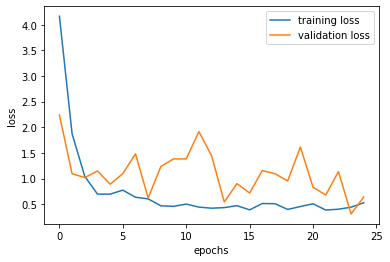

2022-02-27 17:28:42.530898: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Epoch 1/25
19/19 [==============================] - 11s 572ms/step - loss: 0.3484 - accuracy: 0.4683 - val_loss: 0.3741 - val_accuracy: 0.4800
Epoch 2/25
19/19 [==============================] - 11s 559ms/step - loss: 0.4062 - accuracy: 0.4767 - val_loss: 0.3301 - val_accuracy: 0.5050
Epoch 3/25
19/19 [==============================] - 10s 556ms/step - loss: 0.4597 - accuracy: 0.4450 - val_loss: 0.3224 - val_accuracy: 0.5100
Epoch 4/25
19/19 [==============================] - 10s 553ms/step - loss: 0.3619 - accuracy: 0.4750 - val_loss: 0.4943 - val_accuracy: 0.5000
Epoch 5/25
19/19 [==============================] - 11s 557ms/step - loss: 0.2696 - accuracy: 0.4900 - val_loss: 0.4914 - val_accuracy: 0.4850
Epoch 6/25
19/19 [==============================] - 11s 560ms/step - loss: 0.3692 - accuracy: 0.5050 - val_loss: 0.3896 - val_accuracy: 0.5050
Epoch 7/25
19/19 [==============================] - 10s 553ms/step - loss: 0.4215 - accuracy: 0.4333 - val_loss: 0.4122 - val_accuracy: 0.5050

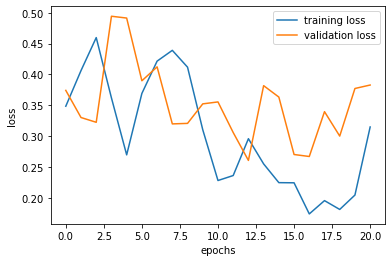

Epoch 1/25
19/19 [==============================] - 11s 569ms/step - loss: 0.2199 - accuracy: 0.4983 - val_loss: 1.0404 - val_accuracy: 0.5800
Epoch 2/25
19/19 [==============================] - 11s 554ms/step - loss: 0.3984 - accuracy: 0.4333 - val_loss: 0.2910 - val_accuracy: 0.5800
Epoch 3/25
19/19 [==============================] - 10s 558ms/step - loss: 0.3168 - accuracy: 0.4867 - val_loss: 0.7395 - val_accuracy: 0.6200
Epoch 4/25
19/19 [==============================] - 10s 553ms/step - loss: 0.2510 - accuracy: 0.4683 - val_loss: 0.7394 - val_accuracy: 0.6350
Epoch 5/25
19/19 [==============================] - 11s 561ms/step - loss: 0.2088 - accuracy: 0.4550 - val_loss: 0.4535 - val_accuracy: 0.6200
Epoch 6/25
19/19 [==============================] - 11s 559ms/step - loss: 0.1827 - accuracy: 0.4750 - val_loss: 0.3782 - val_accuracy: 0.5750
Epoch 7/25
19/19 [==============================] - 10s 556ms/step - loss: 0.2010 - accuracy: 0.4750 - val_loss: 0.3601 - val_accuracy: 0.6000

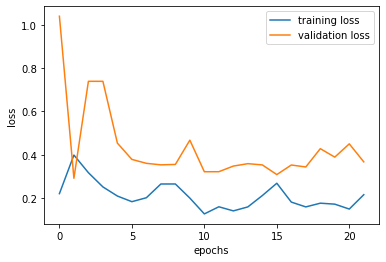

Epoch 1/25
19/19 [==============================] - 10s 555ms/step - loss: 0.2943 - accuracy: 0.4767 - val_loss: 0.3974 - val_accuracy: 0.5400
Epoch 2/25
19/19 [==============================] - 10s 555ms/step - loss: 0.4362 - accuracy: 0.4950 - val_loss: 0.9983 - val_accuracy: 0.5900
Epoch 3/25
19/19 [==============================] - 10s 554ms/step - loss: 0.2481 - accuracy: 0.4633 - val_loss: 0.8399 - val_accuracy: 0.5550
Epoch 4/25
19/19 [==============================] - 11s 560ms/step - loss: 0.3880 - accuracy: 0.4783 - val_loss: 0.8720 - val_accuracy: 0.5700
Epoch 5/25
19/19 [==============================] - 11s 562ms/step - loss: 0.4282 - accuracy: 0.4933 - val_loss: 1.1049 - val_accuracy: 0.5550
Epoch 6/25
19/19 [==============================] - 11s 559ms/step - loss: 0.3272 - accuracy: 0.5083 - val_loss: 0.4406 - val_accuracy: 0.5400
Epoch 7/25
19/19 [==============================] - 10s 556ms/step - loss: 0.3333 - accuracy: 0.5017 - val_loss: 0.2983 - val_accuracy: 0.5300

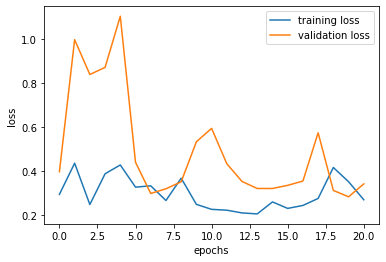

Epoch 1/25
19/19 [==============================] - 11s 566ms/step - loss: 0.3486 - accuracy: 0.4983 - val_loss: 0.2444 - val_accuracy: 0.5350
Epoch 2/25
19/19 [==============================] - 10s 552ms/step - loss: 0.2706 - accuracy: 0.5033 - val_loss: 0.1836 - val_accuracy: 0.5300
Epoch 3/25
19/19 [==============================] - 10s 553ms/step - loss: 0.1786 - accuracy: 0.5083 - val_loss: 0.2442 - val_accuracy: 0.5300
Epoch 4/25
19/19 [==============================] - 10s 552ms/step - loss: 0.2326 - accuracy: 0.5000 - val_loss: 0.2310 - val_accuracy: 0.5300
Epoch 5/25
19/19 [==============================] - 10s 554ms/step - loss: 0.2307 - accuracy: 0.5133 - val_loss: 0.2511 - val_accuracy: 0.5400
Epoch 6/25
19/19 [==============================] - 10s 552ms/step - loss: 0.3136 - accuracy: 0.5150 - val_loss: 0.3064 - val_accuracy: 0.5300
Epoch 7/25
19/19 [==============================] - 11s 560ms/step - loss: 0.2820 - accuracy: 0.5083 - val_loss: 0.3404 - val_accuracy: 0.5250

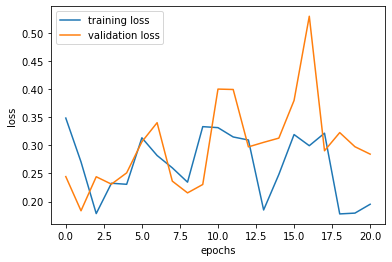

In [7]:
net_cnn = build_cnn()
train(net_cnn, 'cnn_for_5H_v1.1.h5')

2022-02-27 17:48:46.669975: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Percentage misclassified =  [ 51.7  48.3  48.3  51.7  48.3  48.3  48.3  48.3  48.3  48.3  48.3  48.3
  51.7  48.3  51.7  48.3  48.3  51.7  48.3  48.3  48.3  48.3  48.3  48.3
  48.3  48.3  51.7  48.3  48.3  51.7  48.3  48.3  48.3  48.3  48.3  48.3
  48.3  48.3  48.3  48.3  48.3  48.3  51.7  51.7  48.3  51.7  51.7  48.3
  48.3  48.3  51.7  51.7  51.7  48.3  51.7  48.3  48.3  51.7 100.   48.3
  48.3  48.3  51.7  51.7  48.3  48.3  48.3  48.3  51.7  48.3  48.3  48.3
  48.3  48.3  48.3  48.3  51.7  48.3  48.3  48.3  51.7  48.3  48.3  48.3
  48.3  51.7  48.3  51.7  51.7  48.3  48.3  48.3  48.3  48.3  48.3  48.3
  48.3  48.3  48.3  48.3  48.3  48.3  48.3  48.3  48.3  48.3  51.7 100.
  51.7  48.3  48.3  51.7  48.3  51.7  51.7  48.3  48.3 100.   48.3  51.7
  48.3  48.3  51.7 100.   48.3  48.3  48.3  48.3  48.3  51.7  51.7  51.7
  48.3  48.3  48.3  48.3  48.3  48.3  48.3  48.3  48.3 100.   48.3  48.3
  48.3  48.3  48.3  48.3  48.3  48.3  48.3  48.3  48.3  51.7  51.7  51.7
  48.3  48.3  51.7  51.7

/Users/tomas/miniforge3/lib/python3.9/site-packages/matplotlib/text.py:1223: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_38 (Conv2D)          (None, 196, 96, 32)       832       
                                                                 
 batch_normalization_19 (Bat  (None, 196, 96, 32)      128       
 chNormalization)                                                
                                                                 
 conv2d_39 (Conv2D)          (None, 194, 94, 64)       18496     
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 97, 47, 64)       0         
 g2D)                                                            
                                                                 
 flatten_20 (Flatten)        (None, 291776)            0         
                                                                 
 dense_38 (Dense)            (None, 256)             

ImportError: cannot import name 'plot_model' from 'keras.utils' (/Users/tomas/miniforge3/lib/python3.9/site-packages/keras/utils/__init__.py)

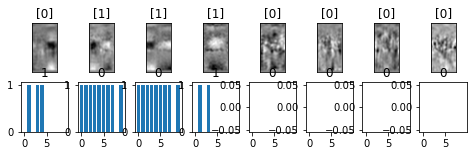

In [8]:
test('cnn_for_5H_trial1.h5')